**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# A Linear Model for Bulldozers

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

In [ ]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [ ]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')

In [ ]:
df_raw['age'] = df_raw.saleYear-df_raw.YearMade

In [ ]:
df, y, nas, mapper = proc_df(df_raw, 'SalePrice', max_n_cat=10, do_scale=True)

In [ ]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df)-n_valid
y_train, y_valid = split_vals(y, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [ ]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

# Linear regression for Bulldozers

## Data scaling

In [ ]:
df.describe().transpose()

count          mean          std  \
SalesID                                401125.0  3.147483e-15     1.000001   
MachineID                              401125.0  2.895953e-15     1.000001   
ModelID                                401125.0 -1.300773e-13     1.000001   
datasource                             401125.0 -6.855920e-13     1.000001   
auctioneerID                           401125.0 -1.064768e-13     1.000001   
YearMade                               401125.0  6.797770e-16     1.000001   
MachineHoursCurrentMeter               401125.0  8.635210e-14     1.000001   
fiModelDesc                            401125.0  1.673709e+03  1263.331163   
fiBaseModel                            401125.0  5.591654e+02   469.310266   
fiSecondaryDesc                        401125.0  3.668504e+01    38.228243   
fiModelSeries                          401125.0  9.192686e+00    27.006859   
fiModelDescriptor                      401125.0  1.223343e+01    29.041950   
fiProductClassDesc                     401125.0  3.226222e+01    22.596618   
state                                  401125.0  2.350832e+01    15.732898   
Hydraulics                             401125.0  4.253801e+00     4.809368   
Tire_Size                              401125.0  3.059847e+00     5.950781   
Undercarriage_Pad_Width                401125.0  4.311895e+00     7.741894   
Stick_Length                           401125.0  6.535564e+00    11.923308   
saleYear                               401125.0 -2.781277e-13     1.000001   
saleMonth                              401125.0  2.443335e-14     1.000001   
saleWeek                               401125.0 -9.469515e-15     1.000001   
saleDay                                401125.0 -1.649883e-15     1.000001   
saleDayofweek                          401125.0  5.134902e-14     1.000001   
saleDayofyear                          401125.0  3.377684e-15     1.000001   
saleis_month_end                       401125.0  3.491732e-14     1.000001   
saleis_month_start                     401125.0  8.367190e-14     1.000001   
saleis_quarter_end                     401125.0  4.067403e-14     1.000001   
saleis_quarter_start                   401125.0  1.443002e-14     1.000001   
saleis_year_end                        401125.0 -1.624260e-14     1.000001   
saleis_year_start                      401125.0  0.000000e+00     0.000000   
...                                         ...           ...          ...   
Blade_Type_Angle                       401125.0  4.143347e-03     0.064235   
Blade_Type_Coal                        401125.0  2.742287e-05     0.005237   
Blade_Type_Landfill                    401125.0  6.232471e-05     0.007894   
Blade_Type_No                          401125.0  1.852290e-03     0.042998   
Blade_Type_None or Unspecified         401125.0  2.849735e-02     0.166389   
Blade_Type_PAT                         401125.0  9.625927e-02     0.294947   
Blade_Type_Semi U                      401125.0  2.148208e-02     0.144985   
Blade_Type_Straight                    401125.0  3.321409e-02     0.179195   
Blade_Type_U                           401125.0  4.641945e-03     0.067974   
Blade_Type_VPAT                        401125.0  8.842630e-03     0.093619   
Blade_Type_nan                         401125.0  8.009773e-01     0.399266   
Travel_Controls_1 Speed                401125.0  2.492988e-05     0.004993   
Travel_Controls_2 Pedal                401125.0  2.846993e-03     0.053281   
Travel_Controls_Differential Steer     401125.0  1.216329e-02     0.109615   
Travel_Controls_Finger Tip             401125.0  6.541602e-03     0.080615   
Travel_Controls_Lever                  401125.0  2.094110e-03     0.045714   
Travel_Controls_None or Unspecified    401125.0  1.743172e-01     0.379383   
Travel_Controls_Pedal                  401125.0  1.037083e-03     0.032187   
Travel_Controls_nan                    401125.0  8.009748e-01     0.399268   
Differential_Type_Limited Slip         401125.0  2.817077e-03   

In [ ]:
X_train, X_valid = split_vals(df, n_trn)

In [ ]:
m = LinearRegression().fit(X_train, y_train)
m.score(X_valid, y_valid)

0.31399415664841568

In [ ]:
m.score(X_train, y_train)

0.60966668735322171

In [ ]:
preds = m.predict(X_valid)

In [ ]:
rmse(preds, y_valid)

0.6197833720320716

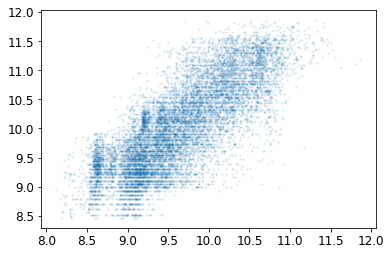

In [ ]:
plt.scatter(preds, y_valid, alpha=0.1, s=2);

## Feature selection from RF

In [ ]:
keep_cols = list(np.load('tmp/keep_cols.npy'))
', '.join(keep_cols)

'YearMade, Coupler_System, ProductSize, fiProductClassDesc, ModelID, Hydraulics_Flow, saleElapsed, fiSecondaryDesc, Enclosure, fiModelDesc, SalesID, fiModelDescriptor, MachineID, ProductGroupDesc, ProductGroup, Drive_System, Hydraulics, state, saleDay, Tire_Size, saleDayofyear'

In [ ]:
df_sub = df_raw[keep_cols+['age', 'SalePrice']]

In [ ]:
df, y, nas, mapper = proc_df(df_sub, 'SalePrice', max_n_cat=10, do_scale=True)

In [ ]:
X_train, X_valid = split_vals(df, n_trn)

In [ ]:
m = LinearRegression().fit(X_train, y_train)
m.score(X_valid, y_valid)

0.67602943126238957

In [ ]:
rmse(m.predict(X_valid), y_valid)

0.42592074374245537

In [ ]:
from operator import itemgetter

In [ ]:
sorted(list(zip(X_valid.columns, m.coef_)), key=itemgetter(1))

[('saleElapsed', -145.64883869187287),
 ('ProductSize_Compact', -0.54007475122954363),
 ('ProductSize_Mini', -0.50048058229134851),
 ('Drive_System_Two Wheel Drive', -0.26738317785805954),
 ('ProductGroupDesc_Skid Steer Loaders', -0.24922453667794642),
 ('ProductGroup_SSL', -0.24922453667794109),
 ('Enclosure_None or Unspecified', -0.24279691741993142),
 ('Enclosure_nan', -0.18422637193293984),
 ('Drive_System_nan', -0.17481049937861393),
 ('Hydraulics_Flow_Standard', -0.16350014357513842),
 ('Enclosure_EROPS AC', -0.13844787814745835),
 ('Enclosure_OROPS', -0.11883972857575564),
 ('ProductSize_nan', -0.091923065651293712),
 ('MachineID', -0.074919067087428459),
 ('Drive_System_Four Wheel Drive', -0.070763049128190758),
 ('Enclosure_EROPS', -0.054481426247864562),
 ('Hydraulics_Flow_High Flow', -0.04086147315765426),
 ('ProductGroupDesc_Track Type Tractors', -0.0040345196773952097),
 ('ProductGroup_TTT', -0.0040345196773863279),
 ('Coupler_System_nan', -0.0033786325283386986),
 ('Tire_

In [ ]:
m = LassoCV().fit(X_train, y_train)
m.score(X_valid, y_valid)

0.634974200475658

In [ ]:
rmse(m.predict(X_valid), y_valid)

0.452103421164379

In [ ]:
m.alpha_

0.015888143202334452

In [ ]:
coefs = sorted(list(zip(X_valid.columns, m.coef_)), key=itemgetter(1))
coefs

[('ProductSize_Mini', -0.32283011739021739),
 ('ProductGroupDesc_Skid Steer Loaders', -0.29197866480532003),
 ('ProductSize_nan', -0.16481153369955914),
 ('Enclosure_OROPS', -0.10072067167233209),
 ('MachineID', -0.077025231732003333),
 ('age', -0.07146167736242677),
 ('saleDayofyear', -0.005420434471588245),
 ('ProductGroup_SSL', -0.00026018612542580649),
 ('state', -0.00020510032574012273),
 ('ModelID', -0.0),
 ('saleElapsed', -0.0),
 ('SalesID', -0.0),
 ('Hydraulics', -0.0),
 ('saleDay', -0.0),
 ('Coupler_System_None or Unspecified', -0.0),
 ('Coupler_System_Yes', -0.0),
 ('ProductSize_Compact', -0.0),
 ('ProductSize_Large', 0.0),
 ('ProductSize_Medium', 0.0),
 ('ProductSize_Small', 0.0),
 ('Hydraulics_Flow_High Flow', -0.0),
 ('Hydraulics_Flow_None or Unspecified', 0.0),
 ('Hydraulics_Flow_Standard', -0.0),
 ('Hydraulics_Flow_nan', 0.0),
 ('Enclosure_EROPS', 0.0),
 ('Enclosure_EROPS AC', -0.0),
 ('Enclosure_NO ROPS', 0.0),
 ('Enclosure_None or Unspecified', -0.0),
 ('Enclosure_nan'

In [ ]:
skip = [n for n,c in coefs if abs(c)<0.01]

In [ ]:
df.drop(skip, axis=1, inplace=True)

# for n,c in df.items():
#     if '_' not in n: df[n+'2'] = df[n]**2

In [ ]:
X_train, X_valid = split_vals(df, n_trn)

In [ ]:
m = LassoCV().fit(X_train, y_train)
m.score(X_valid, y_valid)

0.63678168860529394

In [ ]:
rmse(m.predict(X_valid), y_valid)

0.4509826980922721

In [ ]:
coefs = sorted(list(zip(X_valid.columns, m.coef_)), key=itemgetter(1))
coefs

[('ProductSize_Mini', -0.77420353132504083),
 ('ProductSize_nan', -0.37649627504627403),
 ('ProductGroupDesc_Skid Steer Loaders', -0.31232507784064917),
 ('MachineID', -0.092899281127635194),
 ('Enclosure_OROPS', -0.034526809361612412),
 ('age', -0.024367657576137017),
 ('ProductSize_Large / Medium', 0.08968235308777571),
 ('YearMade', 0.15983396599807115),
 ('Enclosure_EROPS w AC', 0.40652833657308551),
 ('Coupler_System_nan', 0.42191856864836064),
 ('ProductGroupDesc_Motor Graders', 0.49456961585974812)]

In [ ]:
np.savez(f'{PATH}tmp/regr_resid', m.predict(X_train), m.predict(X_valid))